# SHapley Additive exPlanations Demonstration

This notebook demonstrates how to compute and interpret SHAP values and visualizations using scikit-learn. SHAP uses game theory to decompose model predictions into feature contributions and is useful for both global interpretability *and* global insights. 

We'll use the Ames Housing dataset and an XGBoost Regressor model for the regression. 

## Setup

In [1]:
#%pip install shap

In [2]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

## Load and Explore the Data

In [3]:
housing = fetch_openml(name = "house_prices", as_frame = True)
X = housing.data.select_dtypes(include='number').dropna(axis=1) #numeric data only, drop missing 
y = housing.target.astype(float)

X.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,9550,7,5,1915,1970,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,14260,8,5,2000,2000,655,0,490,...,836,192,84,0,0,0,0,0,12,2008


In [4]:
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   LotArea        1460 non-null   int64
 3   OverallQual    1460 non-null   int64
 4   OverallCond    1460 non-null   int64
 5   YearBuilt      1460 non-null   int64
 6   YearRemodAdd   1460 non-null   int64
 7   BsmtFinSF1     1460 non-null   int64
 8   BsmtFinSF2     1460 non-null   int64
 9   BsmtUnfSF      1460 non-null   int64
 10  TotalBsmtSF    1460 non-null   int64
 11  1stFlrSF       1460 non-null   int64
 12  2ndFlrSF       1460 non-null   int64
 13  LowQualFinSF   1460 non-null   int64
 14  GrLivArea      1460 non-null   int64
 15  BsmtFullBath   1460 non-null   int64
 16  BsmtHalfBath   1460 non-null   int64
 17  FullBath       1460 non-null   int64
 18  HalfBath       1460 non-null   int64
 19  Bedroo

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


## Train an XGBoost Regression Model

In [5]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# train model
model = XGBRegressor(n_estimators = 100, objective = 'reg:squarederror')
model.fit(X_train, y_train)

# evaluate model
print(f"Train R²: {model.score(X_train, y_train):.2f}")
print(f"Test R²: {model.score(X_test, y_test):.2f}")

Train R²: 1.00
Test R²: 0.86


## Explain Predictions With SHAP

In [6]:
# initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

In [7]:
# Create dataframe of SHAP values
shap_df = pd.DataFrame(shap_values.values, columns = X_test.columns)
shap_df.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,80.495883,-36.946770,800.100770,-10827.904877,9570.647361,-3237.813421,3133.720793,619.710572,-78.964805,-201.858015,...,-2954.316344,-208.498779,3.653201,-134.719393,-16.059837,-241.591337,-289.839687,-2.695794,-1129.146488,66.798075
1,2242.187516,15.198056,6415.288081,52614.239373,-2918.227920,5334.559220,5611.303949,13150.220533,-25.857106,-1797.470534,...,-595.762265,-2936.870081,707.154092,319.384038,-11.198225,-273.952651,-524.895306,-28.363792,-986.059979,-1308.264511
2,-1527.370503,131.763556,-555.832851,-16270.984389,3878.300686,-10369.262270,-6594.119936,-5146.258711,-104.859573,-735.610160,...,-2561.190798,119.026090,-797.742883,-1982.647932,-28.181992,-150.928596,-298.406410,-72.970271,452.375426,157.334718
3,743.398510,-254.424027,-7989.928094,-6222.751581,7507.312055,-7408.389200,-5871.386732,-137.535106,135.254758,-1116.719636,...,1575.240661,906.914600,232.006791,-3268.997223,-34.293679,-77.265240,-286.230774,13.263834,174.910470,491.886575
4,-1508.440989,857.410822,2427.301673,84229.878370,-4489.627738,27135.411390,9315.534067,12782.511737,-47.781856,-361.934621,...,4094.430267,-816.776697,-887.844687,-117.508912,-31.900101,-267.102417,-551.547716,-10.005945,1102.692017,-808.476004


## Visualizations

### Beeswarm Plot (distribution of SHAP values for each feature)

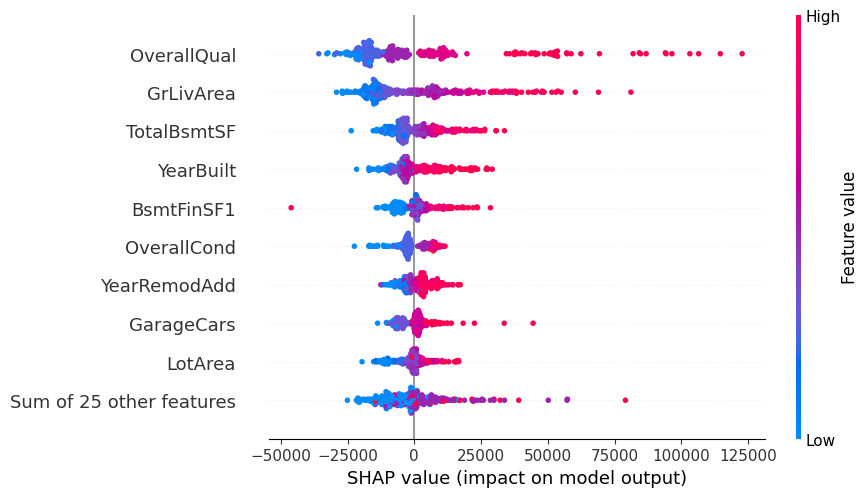

In [8]:
shap.plots.beeswarm(shap_values)

### Beeswarm Plot Interpretation

The SHAP beeswarm plot gives a compact visual summary of how each feature contributes to the model's predictions, across all observations in the dataset. 
- **Each dot** represents an individual observation (row) for that specific feature
- **X-axis (SHAP value)**: How much that feature *pushes* the prediction higher or lower (positive = pushes up, negative = pushes down)
- **Y-axis (featuers)**: Ranked from most impactful at the top (on average), to least impactful at the bottom
- **Color**: Encodes the actual value of the feature (blue = low, red = high)

**Feature Interpretation**

As an example, we can investigate the interpretation of the purportedly *most influential* feature: OverallQual (overall material and finish quality)
- Red dots indicate high values for this feature
- Red dots tend to cluster on the right side of the graph, indicating that they push the predictions *up* - higher quality materials = higher predicted price
- Low values (blue dots) cluster on the left, indicating that lower quality items push predictions *down*

**Key Takeaways** 
- **Top Features**: The model's predictions are dominated by structural/home quality features like `OverallQual`, `GrLivArea`, and `TotalBsmtSF`
- **Interpretability**: The plot reveals how each features affects individual predictions, not just in direction (+/-) but also in *magnitude*
- **Fairness and Auditability**: You can use these plots to see whether any features have *asymmetric effects* or *interaction issues*. `LotArea` for example, might warrant further investigation 

### Bar Plot

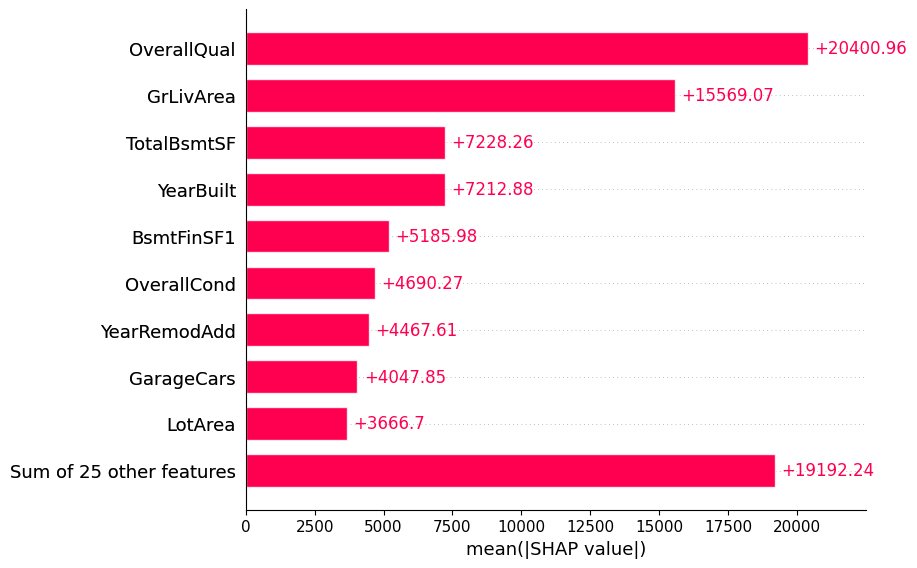

In [9]:
shap.plots.bar(shap_values)

### Bar Plot Interpretation

This bar plot depicts global feature importance using SHAP values. Each bar represents a feature, and it's length (also denoted at the end of each bar) shows the **mean absolute SHAP value** - i.e., **on average, how much that feature influences the model's predictions**, regardless of direction (positively or negatively). Think of using these bars to answer the question: "If I could only keep one feature to explain model predictions, which would explain the most variance?"

**Key Takaways**
- SHAP values help quantify not just which featuers matter, but also *how much* they matter, on average
- `OverallQual` and `GrLivArea` dominate the model - they would be essential to a reduced-feature model
- Features like `YearBuilt`, `TotalBsmtSF`, and `BsmtFinSF1` help the model differentiate homes with similar floor space, but different characteristics or updates. 

### Waterfall Plot (first prediction)

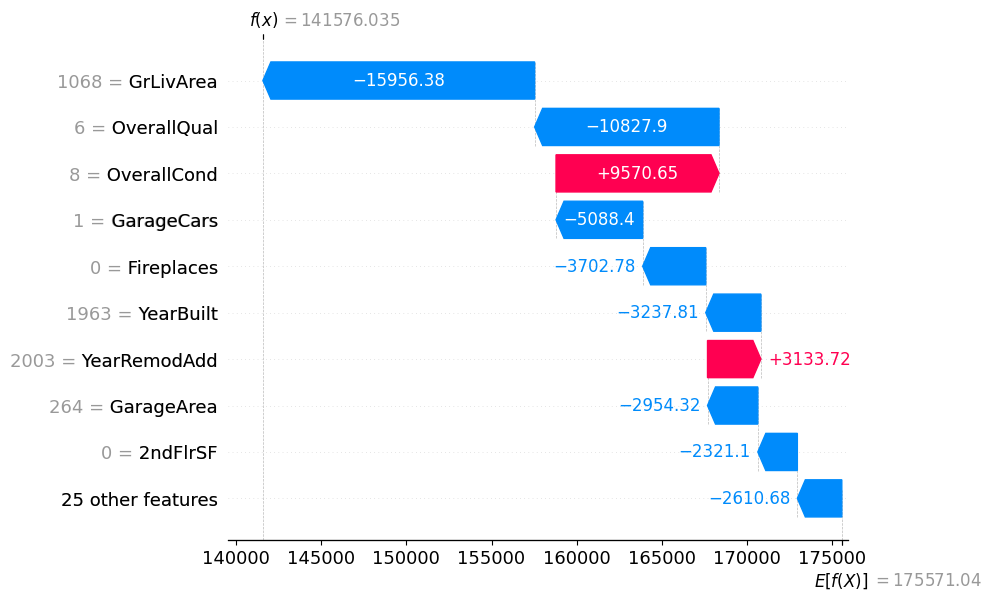

In [10]:
shap.plots.waterfall(shap_values[0])

### Waterfall Plot Interpretation

A SHAP waterfall plot breaks down the individual prediction for a single observation into the contributions of each feature. 
-  It begins from a baseline prediction (the expected value $E\left[f(x) \right]$, i.e., average model prediction across the dataset)
-  Then it adds or subtracts SHAP values from each feature to reach the final prediction $f(x)$ for this instance
-  **Red bars** increase the prediction from the baseline
-  **Blue bars** decrease the prediction from the baseline
-  Features are ordered by absolute impact on this prediction
-  Baseline prediction (expected value):
          $E\left[f(x) \right] = 175571.04%$
- Final prediction for this instance:
          $f(x) = 141576.04$
- The difference means that the model predicted a house price ~**$33,995 lower than average**, and the waterfall plot explains why

**Key Takeaways**
- The house used as an example here is predicted to be valued at ~**$33,995 lower than average** in this dataset
- The reasons it's predicted to have a lower price are largely its **modest build quality `OverallQual`, and its small size `GrLivArea`.
- The house gets small bumps in price from its **good condition `OverallCond` and recent remodel `YearRemodAdd`



### Force Plot (interactive HTML)

In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

### Force Plot Interpretation

The Force Plot tells the same story as the waterfall plot, but on a condensed scale. The "forces" depicted are the influences of the different variables in a positive (red) or negative (blue) direction for the a specific example as it deviates from the dataset average. 
- The baseline prediction (right side, gray bar): This is the average model prediction $E\left[f(x) \right] = 175571.04%$
- The final prediction for the specified example is the middle bold number: $f(x) = 141576.04$
- The **distance between them** is what the plot is explaining, here it's a downward shift of about $33,995
- **Red arrows** represent features that push the prediction higher
- **Blue arrows** represent featuers that pull the prediction lower
- **The length of each arrow** shows how strong that feature's effect was

**Key Takeaway**
- This plot tells the same story as the waterfall plot, but in a way that is considered more intuitive at-a-glance visualization for non-technical stakeholders